### Vighnesh Mane (210021607) - PG

In [ ]:
# Google Colab Setup (reference: Lab 07)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# recall the path in Google Drive (reference: Lab 07)
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', '.DS_Store', 'Video', 'Code', 'Models', 'svm_sift.pkl', 'test_functions.ipynb']


In [ ]:
GOOGLE_DRIVE_PATH

'drive/My Drive/CW_Folder_PG'

In [ ]:
# update opencv (reference: Lab 07)
!pip install opencv-python==4.5.5.64

In [ ]:
# check correct opencv version (reference: Lab 07)
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


In [ ]:
# copy and unzip dataset directly on the Colab server (reference: Lab 07)
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

In [ ]:
# import libraries
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
%matplotlib inline

In [ ]:
# import data from the respective directories (reference : Lab 07)
# Here we have not considered labels_list = None
def loading_im_lab_data(path):
  # getting image files from the directories
  folder_images = [folder for folder in sorted(os.listdir(path)) if folder.endswith('.jpg')]
  images = [cv2.imread(os.path.join(path, folder)) for folder in folder_images]
  # getting label files from the directories
  folder_labels = open("labels/list_label_" + path + ".txt", "r")
  labels = [row.split(' ')[1][0] for row in folder_labels]
  return images, labels
X_train, y_train = loading_im_lab_data("train")
X_test, y_test = loading_im_lab_data("test")

In [ ]:
# (reference: https://www.w3schools.com/python/ref_func_len.asp#:~:text=The%20len()%20function%20returns,of%20characters%20in%20the%20string.)
# checking the length of the training data and testing data
print(len(y_train))
print(len(y_test))

12271
3068


In [ ]:
# (reference : Lab 07)
print(Counter(y_train))
print(Counter(y_test))

Counter({'4': 4772, '7': 2524, '5': 1982, '1': 1290, '3': 717, '6': 705, '2': 281})
Counter({'4': 1185, '7': 680, '5': 478, '1': 329, '6': 162, '3': 160, '2': 74})


### SVM_HOG

In [ ]:
# (reference : Lab 07)
# (reference : https://www.kaggle.com/code/manikg/training-svm-classifier-with-hog-features/notebook)
# applying histograms of gradients on images
from skimage.feature import hog
# Create empty lists for feature descriptors and labels
ppc = 16
cpb = 1
hog_imgs = []
hog_features = []

for z in range(len(X_train)):
    # Identify keypoints and extract descriptors
    img = img_as_ubyte(color.rgb2gray(X_train[z]))
    feature_matrix, hog_img = hog( img, orientations=8, pixels_per_cell=(ppc, ppc),  cells_per_block=(cpb, cpb), visualize=True)
    
    hog_imgs.append(hog_img)
    hog_features.append(feature_matrix)

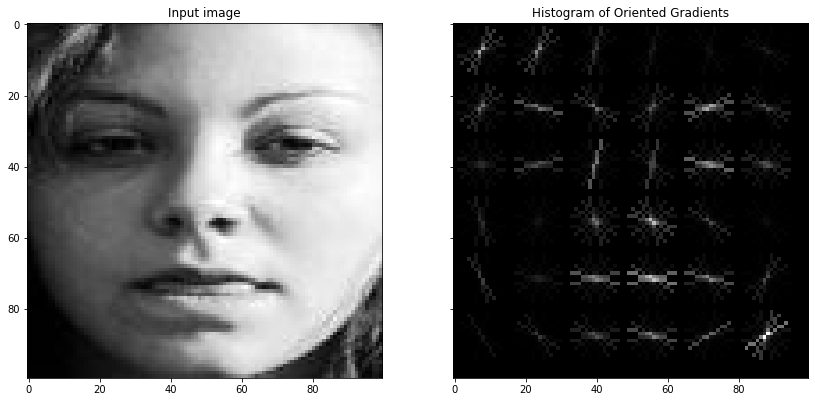

In [ ]:
# (reference: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True) 

ax1.imshow(img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

ax2.imshow(hog_img, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
# (reference : Lab 06 & Lab 07)
# (reference : https://www.kaggle.com/code/manikg/training-svm-classifier-with-hog-features/notebook)
# convert descriptors into histograms of codewords for each image
hist_list = []
for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    feature_matrix, hog_img = hog( img, orientations=8, pixels_per_cell=(ppc, ppc),  cells_per_block=(cpb, cpb), visualize=True)
    hist_list.append(feature_matrix)
hist_array3 = np.vstack(hist_list)

In [ ]:
# (reference : Lab 06)
# create base svm_hog model classifier
class_svc_hog = svm.SVC(kernel='rbf')
class_svc_hog.fit(hog_features,y_train)

SVC()

In [ ]:
#(reference: Lab 07)
# predciting the svc classifier
class_svc_hog_predict = class_svc_hog.predict(hist_array3).tolist()

In [ ]:
#(reference: Lab 07)
import warnings
warnings.filterwarnings("ignore")
#quantitative evaluation of the model's performance
print(f"""Classification report for classifier {class_svc_hog}:
      {metrics.classification_report(y_test, class_svc_hog_predict)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

           1       0.63      0.51      0.57       329
           2       0.91      0.14      0.24        74
           3       0.55      0.04      0.07       160
           4       0.72      0.88      0.79      1185
           5       0.52      0.44      0.48       478
           6       0.68      0.31      0.42       162
           7       0.57      0.71      0.63       680

    accuracy                           0.64      3068
   macro avg       0.65      0.43      0.46      3068
weighted avg       0.64      0.64      0.61      3068




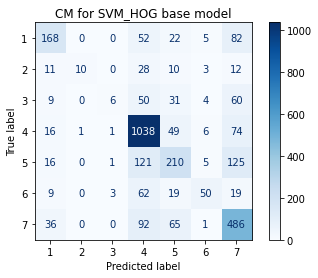

In [ ]:
# (reference : Lab 07)
# confusion matrix for base svm_hog model
metrics.ConfusionMatrixDisplay.from_predictions(y_test, class_svc_hog_predict,cmap=plt.cm.Blues)
plt.title('CM for SVM_HOG base model')
plt.show()

In [ ]:
# (reference : https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/)
# SVM_HOG with best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
grid_hyperpara = {'kernel':["linear", "poly", "rbf"], 'C': [0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001]}
grid_search = GridSearchCV(SVC(), grid_hyperpara,refit = True, verbose=3)
grid_search.fit(hog_features, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.598 total time=  11.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.612 total time=  11.1s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.611 total time=  11.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.590 total time=  10.8s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.563 total time=  10.9s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.570 total time=  22.5s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.607 total time=  23.8s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.602 total time=  23.3s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.572 total time=  22.4s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.539 total time=  21.6s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.389 total time=  34.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

In [ ]:
# (reference: Lab 07)
# create svm model with best hyperparameters obtained from grid search
# Create a classifier: a support vector classifier with best hyperparameters
class_svc_hog_best_para = svm.SVC(kernel='rbf',C = 1,gamma = 0.1)
class_svc_hog_best_para.fit(hog_features, y_train)

SVC(C=1, gamma=0.1)

In [ ]:
# predciting the best svc classifier
class_svc_hog_best_predict = class_svc_hog_best_para.predict(hist_array3).tolist()

In [ ]:
#(reference: Lab 07)
import warnings
warnings.filterwarnings("ignore")
#quantitative evaluation of the model's performance
print(f"""Classification report for classifier {class_svc_hog_best_para}:
      {metrics.classification_report(y_test, class_svc_hog_best_predict)}\n""")

Classification report for classifier SVC(C=1, gamma=0.1):
                    precision    recall  f1-score   support

           1       0.61      0.49      0.54       329
           2       1.00      0.09      0.17        74
           3       0.50      0.02      0.04       160
           4       0.71      0.88      0.79      1185
           5       0.51      0.42      0.46       478
           6       0.68      0.31      0.43       162
           7       0.57      0.70      0.63       680

    accuracy                           0.63      3068
   macro avg       0.65      0.42      0.44      3068
weighted avg       0.63      0.63      0.60      3068




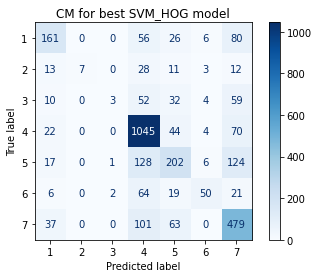

In [ ]:
# (reference : Lab 07)
# confusion matrix for svm_sift model with best hyperparameters
metrics.ConfusionMatrixDisplay.from_predictions(y_test, class_svc_hog_best_predict,cmap=plt.cm.Blues)
plt.title('CM for best SVM_HOG model')
plt.show()

In [ ]:
# (reference : Lab 07)
from joblib import dump, load
dump(class_svc_hog_best_para, 'svm_hog.joblib')

['svm_hog.joblib']

In [ ]:
class_svc_hog_best_para = load('svm_hog.joblib')